In [15]:
import torch
from torch import nn
import numpy as np

In [16]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [17]:
import matplotlib.pyplot as plt

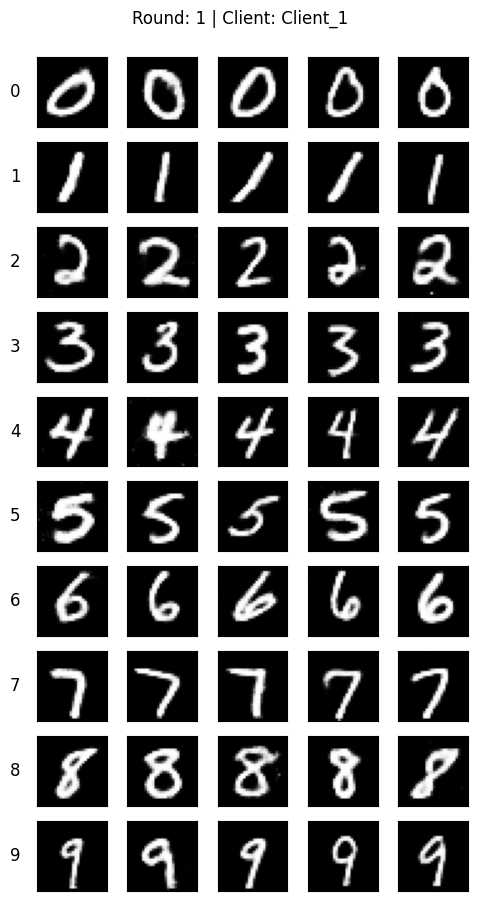

In [46]:
latent_dim = 100
device = "cpu"
net = CGAN(dataset="mnist", latent_dim=latent_dim).to(device)
net.load_state_dict(torch.load('../modelos/model_round_4_mnist.pt'))

# Set the model to evaluation mode
net.eval()

# Assuming netG is your generator model, classes is the total number of classes, and latent_dim is the latent vector size
examples_per_class = 5
classes = 10
batch_size = examples_per_class * classes  # Generate enough images to have `examples_per_class` for each class

# Generate latent vectors and corresponding labels
latent_vectors = torch.randn(batch_size, latent_dim, device=device)
labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

# Generate images
with torch.no_grad():
    generated_images = net(latent_vectors, labels)

# Definir parâmetros da geração de imagens
round_number = 1
client_id = "Client_1"
classes = 10  # Número de classes (0-9)
examples_per_class = 5  # Número de exemplos por classe

# Criar uma figura com 10 linhas e 5 colunas de subplots
fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

# Adiciona título no topo da figura
fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)

# Exibir as imagens nos subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0, :, :], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar o layout antes de calcular as posições
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Reduzir espaço entre colunas
# plt.subplots_adjust(wspace=0.05)

# Adicionar os rótulos das classes corretamente alinhados
fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
for row in range(classes):
    # Obter posição do subplot em coordenadas da figura
    bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
    pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

    # Adicionar o rótulo
    fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

fig.savefig("mnist_CGAN_20r_2e_64b_100z_10c_28i_0001lr_niid_01dir.png", bbox_inches='tight')


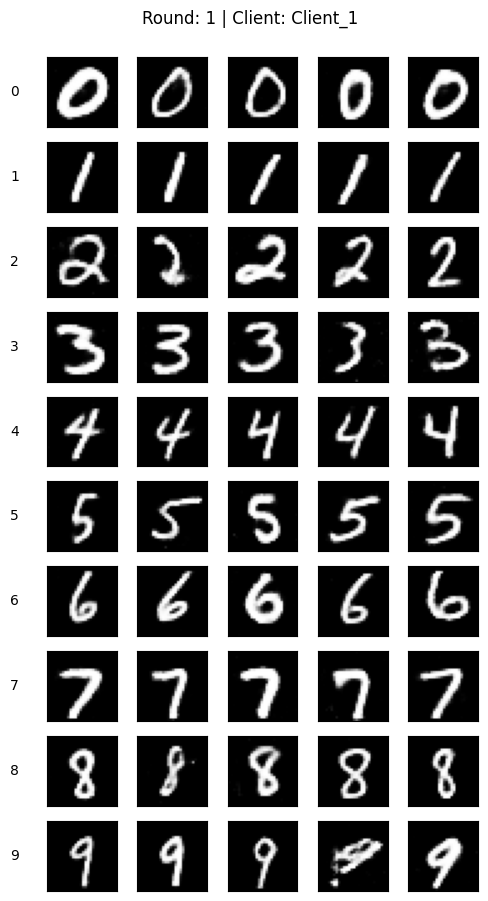

In [34]:
# Definir parâmetros da geração de imagens
round_number = 1
client_id = "Client_1"
classes = 10  # Número de classes (0-9)
examples_per_class = 5  # Número de exemplos por classe

# Criar uma figura com 10 linhas e 5 colunas de subplots
fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

# Adiciona título no topo da figura
fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)

# Exibir as imagens nos subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0, :, :], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar o layout antes de calcular as posições
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Reduzir espaço entre colunas
# plt.subplots_adjust(wspace=0.05)

# Adicionar os rótulos das classes corretamente alinhados
fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
for row in range(classes):
    # Obter posição do subplot em coordenadas da figura
    bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
    pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

    # Adicionar o rótulo
    fig.text(0.02, center_y, str(row), va='center', fontsize=10, color='black')

# Exibir o plot corrigido
plt.show()


In [4]:
from PIL import Image
from IPython.display import Image as IPImage, display

In [ ]:
def create_gif(image_files, output_path, duration=200):
    """
    Cria um GIF animado a partir de uma sequência de imagens.

    Args:
        image_files (list): Lista de caminhos das imagens.
        output_path (str): Caminho para salvar o GIF.
        duration (int): Tempo de exibição de cada frame (em ms).

    Returns:
        None
    """
    frames = [Image.open(img) for img in image_files]  # Carregar imagens
    frames[0].save(output_path, format="GIF", save_all=True, append_images=frames[1:], duration=duration, loop=0)
    display(IPImage(filename=output_path))


In [11]:
import os

In [12]:
os.getcwd()

'/Users/Mara/Documents/Mestrado/Pesquisa/GeraFed/GeraFed'

#### Evolução modelo global

In [ ]:
# Exemplo de uso
image_files = ["../imagens geradas/mnist_CGAN_r0_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r1_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r2_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r3_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r4_100e_64_100z_10c_0.0001lr_niid_01dir.png"]
create_gif(image_files, "global.gif", duration=1000)